
GIT (short for GenerativeImage2Text) is a standard Transformer decoder, conditioned on both CLIP image patch tokens and text tokens. The goal for the model is to simply predict the next text tokens, given the image tokens and the previous text tokens.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/git_architecture.jpg" alt="drawing" width="800"/>

The model itself is pre-trained on a large collection of (image, text) pairs. Note that the authors did not open-source the big GIT and GIT-2 models, but only smaller variants called GIT-base and GIT-large (as well as a lot of fine-tuned checkpoints). Nevertheless, these models are quite impressive and probably one the best open-source variants (for the respective tasks) at the moment!


##VILT $ GIT demo

In [2]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from transformers import ViltProcessor, ViltForQuestionAnswering
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch
import ipywidgets as widgets
from IPython.display import clear_output
import io
import gc

class demo:
    def __init__(self):
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.media=None
        self.uploader=widgets.FileUpload(accept='image/*,.mp4',
                                          multiple=False)
        self.task_selector=widgets.Dropdown(options=["Image Caption",
                                                     "Visual Question Answering"],
                                            value='Image Caption',
                                            disabled=False,)
        self.generate = widgets.Button(description='Generate',
                                       disabled=False,
                                       button_style='', # 'success', 'info', 'warning', 'danger' or ''
                                       tooltip='Click me',
                                       )
        self.question_box = widgets.Text(placeholder='Type something',
                                         disabled=False)
        self.display_output = widgets.Output(layout={'border': '1px solid black'})
        self.itemsA=[self.question_box,                                                    ## zip up all the active buttons to an item list
                    self.display_output]

        self.itemsB=[self.uploader,                                                    ## zip up all the active buttons to an item list
                    self.task_selector,
                    self.generate]
        self.containerA=widgets.HBox(self.itemsA)
        self.containerB=widgets.HBox(self.itemsB)
        self.uploader.observe(self.upload_media,names="_counter")
        self.generate.on_click(self.main_action)
        self.display_reset()
        with self.display_output:
            print("Hello world :)")
        

    def display_reset(self):
        
        clear_output()
        display(self.media)
        display(self.containerB)
        display(self.containerA)

    def upload_media(self, change):
        filename = next(iter(self.uploader.value))                                 # gets the properties and contents of the uploaded text fil                                                                  
        self.uploaded_file=self.uploader.value[filename]["content"]     # gets the contents of the uploaded file
        self.media = Image.open(io.BytesIO(self.uploaded_file),)
        self.display_reset()

    def caption_it(self):
        self.processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
        self.model = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco")
        self.model.to(self.device)
        inputs = self.processor(images=self.media, return_tensors="pt")
        pixel_values = inputs.pixel_values.to(self.device)
        generated_ids = self.model.generate(pixel_values=pixel_values, max_length=50)
        with self.display_output:
            print()
            print("Generated caption:", self.processor.batch_decode(generated_ids, skip_special_tokens=True))
            print()
        gc.collect()
        self.display_reset()

    def VQA(self):
        self.processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
        self.model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
        self.model.to(self.device)
        question = str(self.question_box.value)
        encoding = self.processor(self.media, question, return_tensors="pt").to(self.device)

        # forward pass
        outputs = self.model(**encoding)
        logits = outputs.logits
        idx = logits.argmax(-1).item()
        
        with self.display_output:
            print("Question: ", str(self.question_box.value))
            print()
            print("Predicted answer:", self.model.config.id2label[idx])
            print()
        gc.collect()
        self.display_reset()

    def main_action(self,instance):
        if self.task_selector.value== "Image Caption":
            self.caption_it()
        else:
            self.VQA()





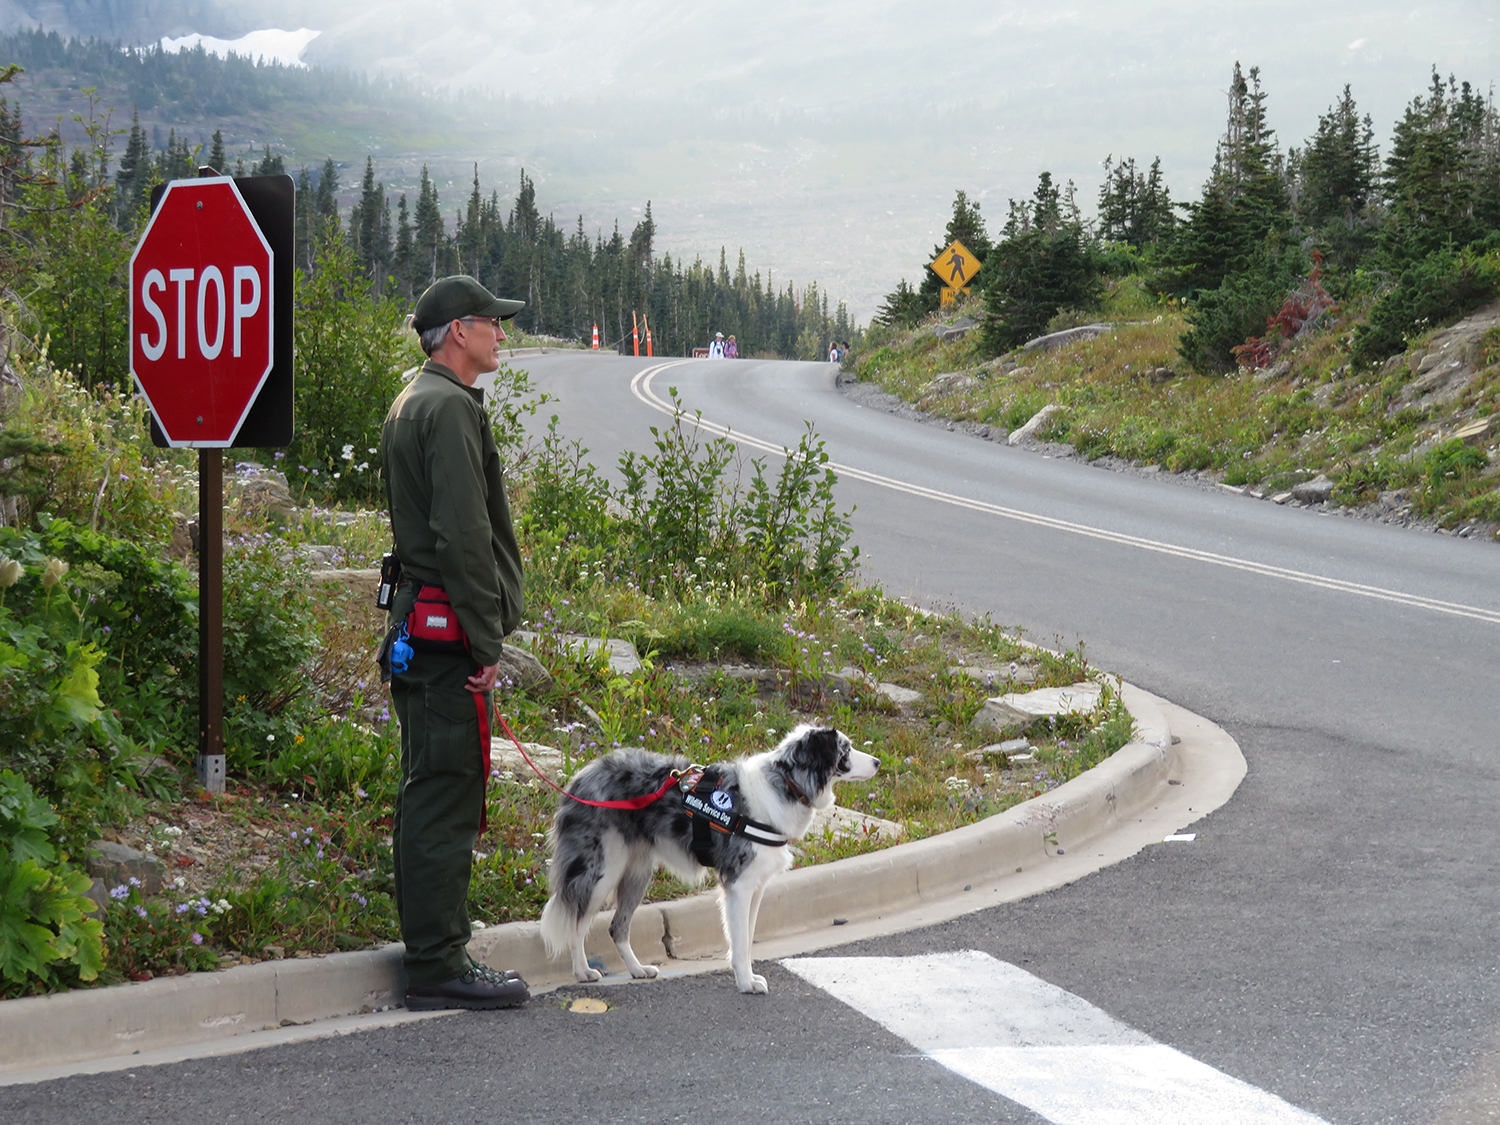

In [4]:
demo()